# Research at Yandex.Afisha : optimize marketing expenses

Analytical department at Yandex.Afisha has a task to help optimize marketing expenses.

based on:
* Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
* Dump file with all orders for the period
* Marketing expenses statistics

to study:
* How people use the product
* When they start to buy
* How much money each customer brings
* When they pay off


## Step 1. Openning the data file and studying the general information. 

In [1]:
import pandas as pd
import numpy as np 
import math as mt
from math import factorial
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats as st
from collections import Counter
import seaborn as sns
import warnings
from datetime import date, timedelta
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
#Let’s read them from the csv and check what we have there.
#1st table from the csv file will be saved as visits:

visits = pd.read_csv('/datasets/visits_log_us.csv', sep=',')
visits.info()
display(visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
#2nd table from the csv file will be saved as table2:

orders = pd.read_csv('/datasets/orders_log_us.csv', sep=',')
orders.info()
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [4]:
#3rd table from the csv file will be saved as table2:

costs = pd.read_csv('/datasets/costs_us.csv', sep=',')
costs.costs = costs.costs.astype(int)
costs.info()
display(costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null int64
dtypes: int64(2), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75
1,1,2017-06-02,62
2,1,2017-06-03,36
3,1,2017-06-04,55
4,1,2017-06-05,57


In [5]:
costs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null int64
dtypes: int64(2), object(1)
memory usage: 59.7+ KB


In [6]:
visits.describe()

,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


In [7]:
#Let's make sure each column contains the correct data type
#convert columns to date type in visits table: End Ts, Start Ts
visits['End Ts'] =  pd.to_datetime(visits['End Ts'], format="%Y-%m-%d %H:%M")
visits['Start Ts'] =  pd.to_datetime(visits['Start Ts'], format="%Y-%m-%d %H:%M")

#convert columns to date type in orders table: Buy Ts
orders['Buy Ts'] =  pd.to_datetime(orders['Buy Ts'], format="%Y-%m-%d %H:%M")

#convert columns to date type in costs table: dt
costs['dt'] =  pd.to_datetime(costs['dt'], format="%Y-%m-%d %H:%M")

In [8]:
visits.columns = map(str.lower, visits.columns)
visits.columns = visits.columns.str.replace(' ', '_')
orders.columns = map(str.lower, orders.columns)
orders.columns = orders.columns.str.replace(' ', '_')
costs.columns = map(str.lower, costs.columns)
costs.columns = costs.columns.str.replace(' ', '_')

In [9]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


### Conclusion

There are 3 data sets. Every data set is saved as a variable:

**visits**

Its total length is 359400 rows, every row represents one server log with data on website visits and its characteristics in columns: Uid — user's unique identifier; Device — user's device; Start Ts — session start date and time; End Ts — session end date and time; Source Id — identifier of the ad source the user came from.

**orders**

Its total length is 50415 rows, every row represents one order and its characteristics in columns: Uid — unique identifier of the user making an order; Buy Ts — order date and time; Revenue — Yandex.Afisha's revenue from the order.

**costs**

Its total length is 2542 rows, every row represents one marketing expense and its characteristics in columns: source_id — ad source identifier; dt — date; costs — expenses on this ad source on this day.
    
As part of out analysis, we made sure each column contains the correct data type and converted below elements to date time format:
- visits table: End Ts, Start Ts
- orders table: Buy Ts
- costs table: dt .

## Step 2. Making reports and calculating metrics


### Part 1: Product:
    * How many people use it every day, week, and month?
    * How many sessions are there per day? (One user might have more than one session.)
    * What is the length of each session?
    * How often do users come back?

#### 1.1. How many people use it every day, week, and month

In [81]:
visits['visits_week']  = visits['start_ts'].dt.week 
#visits['visits_week']

In [11]:
visits['visits_year']  = visits['start_ts'].dt.year
visits['visits_month'] = visits['start_ts'].dt.month
visits['visits_week']  = visits['start_ts'].dt.week 
visits['visits_date'] = visits['start_ts'].dt.date

dau_total = visits.groupby('visits_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['visits_week','visits_year']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['visits_month', 'visits_year']).agg({'uid': 'nunique'}).mean()

sticky_wau = dau_total/wau_total*100
print('how often users return to the app (week)',int(sticky_wau),'%')
sticky_mau = dau_total/mau_total*100
print('how often users return to the app (month)',int(sticky_mau),'%')

print('the number of daily active (unique) users:',int(dau_total))
print('the number of weekly active users:',int(wau_total))
print('the number of monthly active users:',int(mau_total))

how often users return to the app (week) 15 %
how often users return to the app (month) 3 %
the number of daily active (unique) users: 907
the number of weekly active users: 5716
the number of monthly active users: 23228


In [12]:
dau = visits[['uid','visits_date','visits_year']]
dau = dau.groupby(['visits_date','visits_year']).agg({'uid':'count'}).sort_values(by = 'uid', ascending=False).reset_index()

wau = visits[['uid','visits_week','visits_year']]
wau = wau.groupby(['visits_week','visits_year']).agg({'uid':'count'}).sort_values(by = 'uid', ascending=False).reset_index()

mau = visits[['uid','visits_month','visits_year']]
mau = mau.groupby(['visits_month','visits_year']).agg({'uid':'count'}).sort_values(by = 'uid', ascending=False).reset_index()


In [13]:
wau.query('visits_week == 22')

,visits_week,visits_year,uid
33,22,2018,5857
52,22,2017,2309


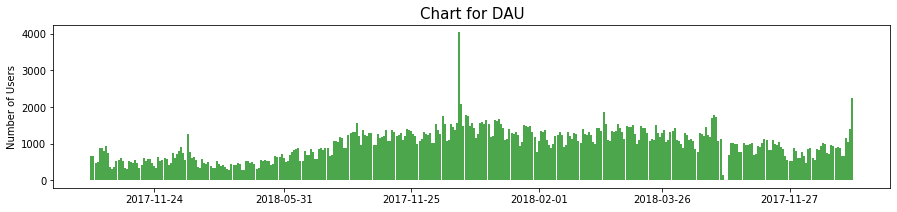

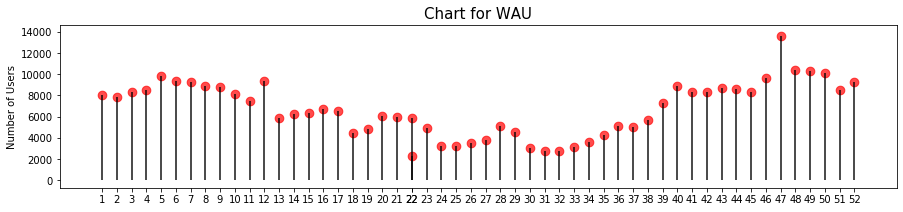

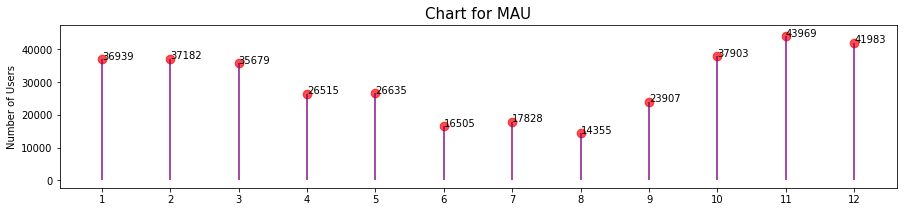

In [14]:
fig,ax=plt.subplots(figsize=(15,3))
ax.vlines(x=dau.visits_date, ymin=0, ymax=dau.uid, color='green', alpha=0.7,linewidth=2)
ax.set_title('Chart for DAU', fontdict={'size':15})
ax.set_ylabel('Number of Users')
ax.set_xticklabels(dau.visits_date)


fig,ax=plt.subplots(figsize=(15,3))
ax.vlines(x=wau.visits_week, ymin=0, ymax=wau.uid, color='black', alpha=0.7,linewidth=2)
ax.set_title('Chart for WAU', fontdict={'size':15})
ax.set_ylabel('Number of Users')
ax.set_xticks(wau.visits_week)
ax.scatter(x=wau.visits_week, y=wau.uid, s=75, color='red', alpha=0.7)

fig,ax=plt.subplots(figsize=(15,3))
ax.vlines(x=mau.visits_month, ymin=0, ymax=mau.uid, color='purple', alpha=0.7,linewidth=2)
ax.set_title('Chart for MAU', fontdict={'size':15})
ax.set_ylabel('Number of Users')
ax.set_xticks(mau.visits_month)
ax.scatter(x=mau.visits_month, y=mau.uid, s=75, color='red', alpha=0.7)
for row in mau.itertuples():
    ax.text(row.visits_month, row.uid+30, s=round(row.uid, 2))


We can see that 3% if unique users return to the app on the weekly (sticky WAU) basis and 15 % on the monthly basis (sticky MAU)
- the number of daily active (unique) users: 907
- the number of weekly active users: 5716
- the number of monthly active users: 23228

Note: our data contains visits from June 2017 through May 2018, in 2017 week 22 was in June, while in 2018 it was in May, that's why we can see it twice on our WAU graph.

We saw that the minimum of users was in the week 22 in 2017 (beginning of our data set).

We saw the spike of the daily and monthly active users in Nov'17 (that is around week 46-47).

#### 1.2. How many sessions are there per day

In [15]:
#Now let's check how many sessions are there per day (note: one user might have more than one session)
#we'll build a line graph with total session count per day

visits
visits1 = visits[['uid','visits_date']]
visits1 = visits1.groupby('visits_date').agg({'uid':'count'}).sort_values(by = 'uid', ascending=False).reset_index()


In [16]:
print(visits1.head())

  visits_date   uid
0  2017-11-24  4042
1  2018-05-31  2256
2  2017-11-25  2089
3  2018-02-01  1878
4  2018-03-26  1796


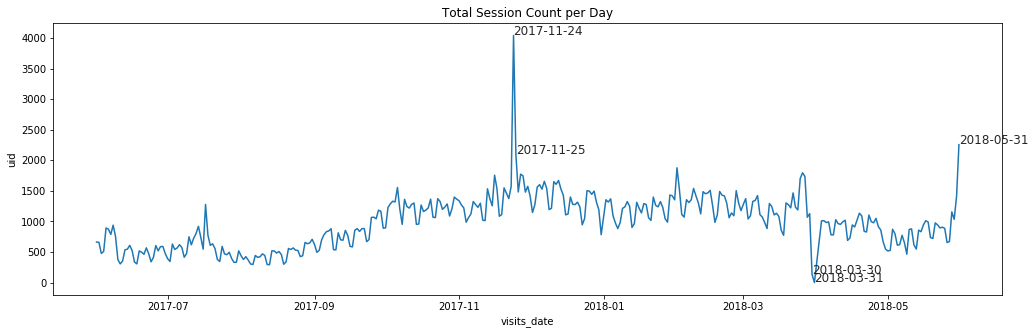

In [17]:
plt.figure(figsize=(17,5))
plt.title('Total Session Count per Day')
sns.lineplot(x = "visits_date", y = "uid",data=visits1)
sns.set(style='darkgrid')
# Using a variable to manage how above/below text should appear
slider = 10
for i in range(visits1.shape[0]):
    if visits1['uid'].iloc[i] > 2000 or visits1['uid'].iloc[i] < 200:
        plt.text(visits1.visits_date.iloc[i], 
                 visits1['uid'].iloc[i] + slider,  
                 visits1['visits_date'].iloc[i])
plt.show()

we can see that in average there september through march there are around 1000-1500 sessions a day

we have couple of spikes on 24-25/11/2017 with more than 4000 sessions and 31/05/2018 with 2300 sessions and a drop to 0 on 30-31/03/2018.

In [18]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visits_week,visits_year,visits_month,visits_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,51,2017,12,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,8,2018,2,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,26,2017,7,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,2018,5,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,52,2017,12,2017-12-27


#### 1.3. What is the length of each session

In [19]:
#Let's see what is the length of each session

visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [20]:
visits.head()

,device,end_ts,source_id,start_ts,uid,visits_week,visits_year,visits_month,visits_date,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,51,2017,12,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,8,2018,2,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,26,2017,7,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,20,2018,5,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,52,2017,12,2017-12-27,0


Text(330.0, 128845.70999999999, 'Median: 300.0')

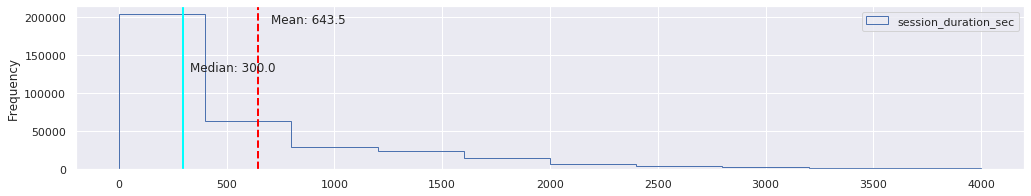

In [21]:
plt.figure(figsize=(17,3))
visits['session_duration_sec'].plot(
    kind='hist', y='session_duration_sec', 
    histtype='step', range=(0, 4000), grid=True, legend=True)
plt.axvline(visits['session_duration_sec'].mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(visits['session_duration_sec'].median(), color='cyan', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(visits['session_duration_sec'].mean()*1.1, max_ylim*0.9, 
         'Mean: {:.1f}'.format(visits['session_duration_sec'].mean()))
plt.text(visits['session_duration_sec'].median()*1.1, max_ylim*0.6, 
         'Median: {:.1f}'.format(visits['session_duration_sec'].median()))


Text(0, 0.5, 'seconds')

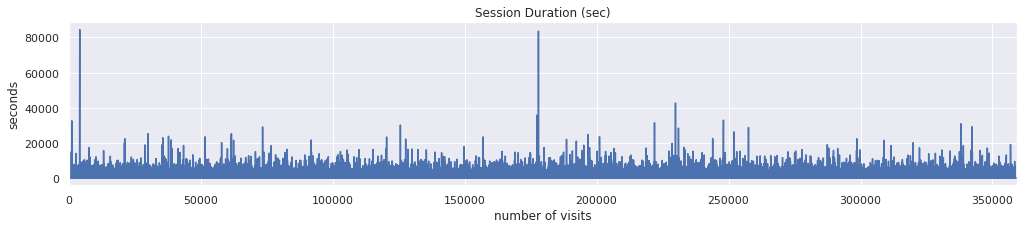

In [22]:
plt.figure(figsize=(17,3))
plt.title('Session Duration (sec)')
visits.session_duration_sec.plot()
plt.xlabel("number of visits")
plt.ylabel("seconds")

In [23]:
visits.session_duration_sec.describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration_sec, dtype: float64

While checking the session duration we saw that the average session lasts 643 sec, max is 84480 sec (almost 24h) and the median is 300 sec and standard deviation is 1016 sec.

#### 1.4. How often do users come back

In [24]:
# let's find first activity date for every user
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
first_activity_date = visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'


In [25]:
user_activity = visits.join(first_activity_date,on='uid')
user_activity['first_activity_date'] = pd.to_datetime(user_activity['first_activity_date']).dt.normalize()


In [26]:
# let's find first activity month for every user

user_activity['start_ts'] = user_activity['start_ts'].astype('datetime64[D]')
user_activity['activity_month'] = user_activity['start_ts'].astype('datetime64[M]')
user_activity['first_activity_month'] = user_activity['first_activity_date'].astype('datetime64[M]')

In [27]:
# let's find cohort lifetime

user_activity['cohort_lifetime'] = user_activity['activity_month'] - user_activity['first_activity_month']
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'] / np.timedelta64(1,'M')
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'].astype(int)
user_activity.head(3)


,device,end_ts,source_id,start_ts,uid,visits_week,visits_year,visits_month,visits_date,session_duration_sec,first_activity_date,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20,16879256277535980062,51,2017,12,2017-12-20,1080,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19,104060357244891740,8,2018,2,2018-02-19,1680,2018-02-19,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01,7459035603376831527,26,2017,7,2017-07-01,0,2017-07-01,2017-07-01,2017-07-01,0


In [28]:
# let's find retention

cohorts = user_activity.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [29]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [30]:
initial_users_count

,first_activity_month,cohort_users
0,2017-06-01,13259
10,2017-07-01,13140
19,2017-08-01,10181
28,2017-09-01,16704
34,2017-10-01,25977
41,2017-11-01,27248
46,2017-12-01,25268
51,2018-01-01,22624
55,2018-02-01,22197
58,2018-03-01,20589


In [31]:
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts.head()


,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,2,713,13259,0.053775
2,2017-06-01,3,814,13259,0.061392
3,2017-06-01,4,909,13259,0.068557
4,2017-06-01,5,947,13259,0.071423


In [32]:
cohorts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 62
Data columns (total 5 columns):
first_activity_month    63 non-null datetime64[ns]
cohort_lifetime         63 non-null int64
uid                     63 non-null int64
cohort_users            63 non-null int64
retention               63 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 3.0 KB


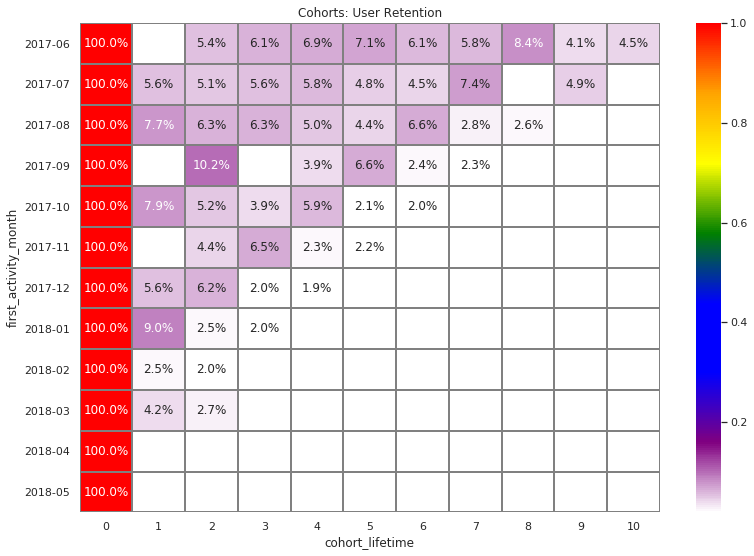

In [33]:
# let's plot retention heatmap
import matplotlib.colors as mcolors

retention_pivot = cohorts.pivot_table(
    index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(
    retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', 
    cmap = mcolors.LinearSegmentedColormap.from_list(
    name='test', 
    colors=['white','purple','blue','blue','green','yellow','orange','red'])
).set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
norm = plt.Normalize(-100,100)


plt.show()

When checking the Retention heatmap of how many users stay loyal to our service we can see that the best result was for users from September'17 cohort who came back the second period (10%) and in January'18 - in the first period (9%).

### Part 2: Sales

    * When do people start buying? (In KPI analysis, we're usually interested in knowing the time that elapses between registration and conversion — when the user becomes a customer. For example, if registration and the first purchase occur on the same day, the user might fall into category Conversion 0d. If the first purchase happens the next day, it will be Conversion 1d. You can use any approach that lets you compare the conversions of different cohorts, so that you can determine which cohort, or marketing channel, is most effective.)
    * How many orders do they make during a given period of time?
    * What is the average purchase size?
    * How much money do they bring? (LTV)

#### 2.1. When do people start buying

In [34]:
#Let's check when do people start buying
#for each user, let's find date of first order
first_order_dates = orders.groupby('uid').agg({'buy_ts':'min'}).reset_index()
first_order_dates.columns= ['uid','first_order_date']
 
#for each user, let's find date of first session
first_session_dates = visits.groupby('uid').agg({'start_ts':'min'}).reset_index()
first_session_dates.columns= ['uid','first_session_date']
 
#let's merge tables on uid
conversion = pd.merge(first_session_dates, first_order_dates, on='uid')
 
#let's calculate time between first session and first order
conversion['conversion_time_days'] = (conversion['first_order_date'] - conversion['first_session_date']).dt.days
 
avg_conversion_time = conversion['conversion_time_days'].mean()

#print(avg_conversion_time)
#(conversion['uid']).nunique()/(visits['uid']).nunique()

In [35]:
conversion['first_session_month'] = conversion['first_session_date'].astype('datetime64[M]')

In [36]:
def conversion_time(row):
    conversion_time = row['conversion_time_days']
    
    if conversion_time == 0:
        return '0d'
    elif conversion_time <= 7:
        return '7d'
    elif conversion_time <= 14:
        return '14d'
    elif conversion_time <= 30:
        return '30d'
    return '31+d'
conversion['conversion_time'] = conversion.apply(conversion_time, axis = 1)
#conversion

In [37]:
#conversion

In [38]:
cohorts_conv = conversion.groupby(['first_session_month','conversion_time']).agg({'uid':'nunique'}).reset_index()
#cohorts_conv

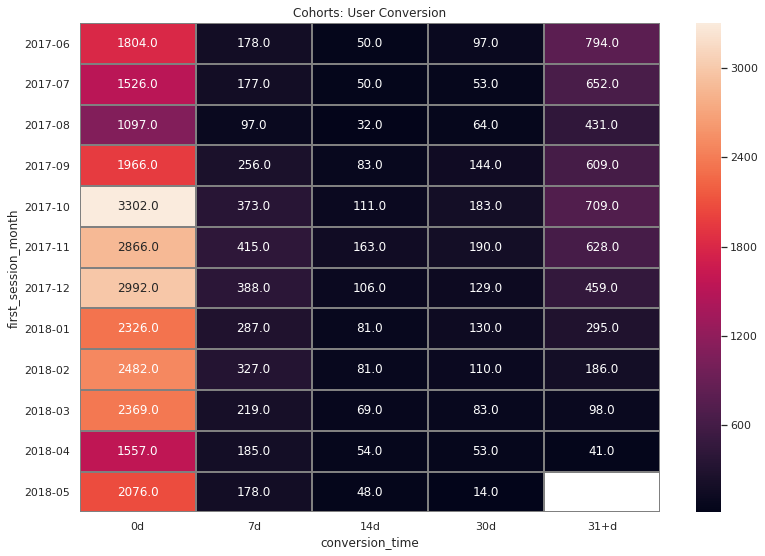

In [39]:
# let's plot retention heatmap
conversion_pivot = cohorts_conv.pivot_table(
    index='first_session_month',columns='conversion_time',values='uid',aggfunc='sum')
conversion_pivot = conversion_pivot.reindex(['0d','7d', '14d','30d','31+d'], axis=1)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Conversion')
sns.heatmap(
    conversion_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray'
).set_yticklabels(conversion_pivot.index.strftime('%Y-%m'))
plt.show()

While checking convrsion by monthly cohorts - from first session, we can see that the best result was in Oct'17 cohort with 3302 d0 conversions, then was Dec'17 cohort with 2992 d0 conversions. The best within first 7 days was Nov'17 cohort with 415 conversions. The best within first 14 days was Nov'17 cohort with 163 conversions. The best within first 30 days was Nov'17 cohort with 190 conversions. The best within more than 30 days was Jun'17 cohort with 794 conversions. 

There are 36523 unique users that were converted (from 228169 users (visits)) that is 16%. With the average convertion time of 17 days.

Now let's find how many users were converted:
    - Conversion 0d(%) - the of users whose difference is equal to 0/registrations
    - Conversion 7d(%) - the users that converted up till 7th day ( the difference is less or equal to 7)/registrations
    - Conversion 14d(%) - the users that converted up till 7th day ( the difference is less or equal to 14)/registrations
    - Conversion 30d(%) - the users that converted up till 7th day ( the difference is less or equal to 30)/registrations


In [40]:
print('Conversion 0d(%) - users who purchased at the registration date: ',
      int(conversion.query('conversion_time_days == 0').count()['uid']/(visits['uid']).nunique() *100), '%')
print('Conversion 7d(%) - users who purchased up till 7th day',
      int(conversion.query('conversion_time_days <= 7').count()['uid']/(visits['uid']).nunique() *100), '%')
print('Conversion 14d(%) - users who purchased up till 14th day',
      int(conversion.query('conversion_time_days <= 14').count()['uid']/(visits['uid']).nunique() *100), '%')

print('Conversion 300d(%) - users who purchased up till 30th day',
      int(conversion.query('conversion_time_days <= 30').count()['uid']/(visits['uid']).nunique() *100), '%')

Conversion 0d(%) - users who purchased at the registration date:  11 %
Conversion 7d(%) - users who purchased up till 7th day 12 %
Conversion 14d(%) - users who purchased up till 14th day 13 %
Conversion 300d(%) - users who purchased up till 30th day 13 %


In [41]:
orders['visits_year']  = orders['buy_ts'].dt.year
orders['visits_month'] = orders['buy_ts'].dt.month
orders['visits_week']  = orders['buy_ts'].dt.week
orders['visits_date'] = orders['buy_ts'].dt.date


#### 2.2. How many orders do users make during a given period of time

In [42]:
#Now let's find  how many orders do users make during a given period of time

orders_stat = orders.merge(visits, on=['visits_date', 'uid']).drop_duplicates().fillna(0)
orders_stat = orders_stat[['source_id','revenue','uid','visits_year_x','visits_month_x','visits_week_x','visits_date']]
orders_stat.drop_duplicates()

,source_id,revenue,uid,visits_year_x,visits_month_x,visits_week_x,visits_date
0,1,17.00,10329302124590727494,2017,6,22,2017-06-01
1,2,0.55,11627257723692907447,2017,6,22,2017-06-01
2,2,0.37,17903680561304213844,2017,6,22,2017-06-01
3,2,0.55,16109239769442553005,2017,6,22,2017-06-01
4,3,0.37,14200605875248379450,2017,6,22,2017-06-01
...,...,...,...,...,...,...,...
55022,4,0.92,15854392578508828030,2018,5,22,2018-05-31
55023,2,3.67,1805512004303848280,2018,5,22,2018-05-31
55024,4,4.64,12296626599487328624,2018,5,22,2018-05-31
55026,10,5.80,11369640365507475976,2018,5,22,2018-05-31


In [43]:
orders_stat = orders_stat.query('revenue > 0')

In [44]:
#orders_stat

In [45]:
orders_stat2 = orders_stat[['uid','visits_date']].groupby(['visits_date']).count().reset_index()



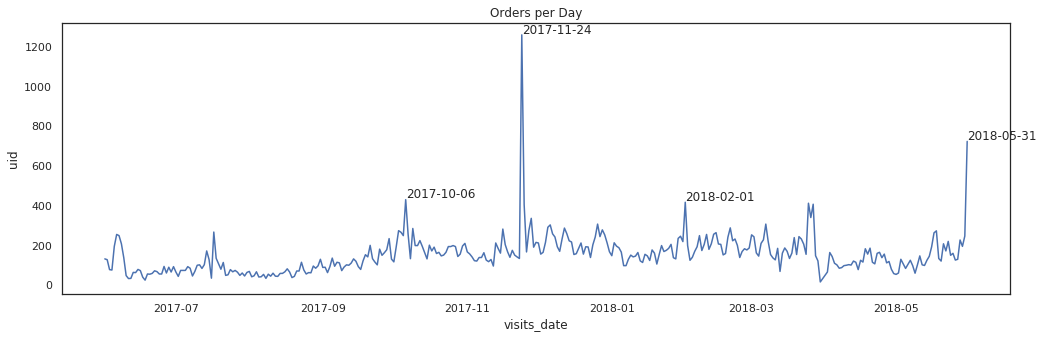

In [46]:
plt.figure(figsize=(17,5))
plt.title('Orders per Day')
sns.set_style("darkgrid")
sns.lineplot(data=orders_stat2, x="visits_date",y="uid", legend="full", palette="Set1")
# Using a variable to manage how above/below text should appear
slider = 10
for i in range(orders_stat2.shape[0]):
    if orders_stat2['uid'].iloc[i] > 410 :
        plt.text(orders_stat2.visits_date.iloc[i], 
                 orders_stat2['uid'].iloc[i] + slider,  
                 orders_stat2['visits_date'].iloc[i])
plt.show()

We can see that top 3 orders days were with more than 1200 orders were done on 24/11/2017; 721 on 31/05/2018 and 428 on 10/06/2017. From September 2017 to April we can see stable fluctuations mainly between 200 and 400 dayly orders except the spike that was mentioned.

In [47]:
orders_stat2.sort_values(by = 'uid', ascending = False).head(3)

,visits_date,uid
176,2017-11-24,1257
362,2018-05-31,721
127,2017-10-06,428


#### 2.3. What is the average purchase size

In [48]:
#Let's see what is the average purchase size

orders_stat3 = orders_stat[['revenue','visits_date']].groupby(['visits_date']).mean().reset_index()
print(orders_stat3.query('revenue > 20'))

    visits_date    revenue
13   2017-06-14  27.857213
112  2017-09-21  26.783586
192  2017-12-10  28.698631


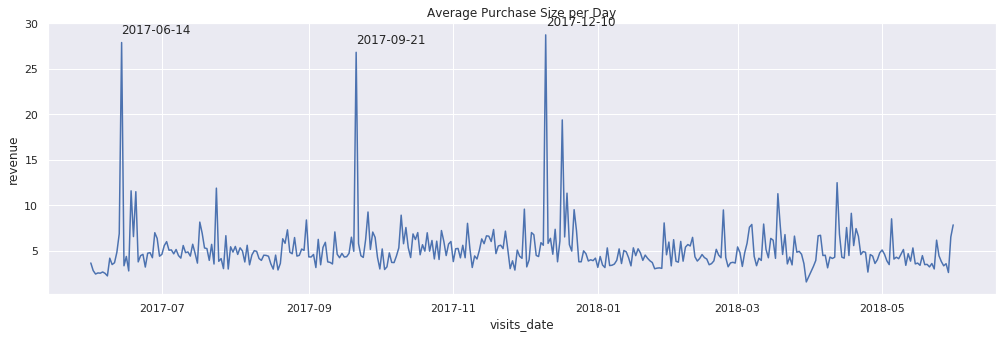

In [49]:
plt.figure(figsize=(17,5))
plt.title('Average Purchase Size per Day')
sns.lineplot(data=orders_stat3, x="visits_date",y="revenue", legend="full", palette="Set1")
# Using a variable to manage how above/below text should appear
slider = 1
for i in range(orders_stat2.shape[0]):
    if orders_stat3['revenue'].iloc[i] > 20:
        plt.text(orders_stat3.visits_date.iloc[i], 
                 orders_stat3['revenue'].iloc[i] + slider,  
                 orders_stat3['visits_date'].iloc[i])
plt.show()

Regarding average purchase size per day, the top 3 of them brought 28, 27 and 29 on 14/06/2017, 21/09/2017, 10/12/2017 accordingly.

#### 2.4. How much money do they bring (LTV)

In [50]:
#to find LTV, let's check cohorts based on their first visit and then check their life time value
order_dates_rev = orders.groupby(['uid', 'visits_date']).agg({'buy_ts':'min', 'revenue':'sum'}).reset_index().rename(columns={'buy_ts':'first_order_date'})
#order_dates_rev

In [51]:
ltv1 = pd.merge(conversion,order_dates_rev, on=['uid'])
ltv1['first_order_month'] = ltv1['first_order_date_x'].astype('datetime64[M]')
ltv1['order_month'] = ltv1['visits_date'].astype('datetime64[M]')
#ltv1

In [52]:
ltv1['age'] = (ltv1['order_month'] - ltv1['first_order_month']) / np.timedelta64(1, 'M')
ltv1['age'] = ltv1['age'].round().astype('int')
#ltv1

In [53]:
ltv = ltv1.groupby(['first_order_month', 'age']).agg({'uid':'nunique', 'revenue':'sum'}).reset_index()
ltv['ltv'] = ltv['revenue'] / ltv['uid']
#ltv

In [54]:
# let's calculate values for the pivot table
ltv_pivot = ltv.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean').round()
ltv_pivot.fillna('')

ltv_pivot

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,5.0,16.0,18.0,36.0,24.0,22.0,31.0,25.0,19.0,27.0,26.0,10.0
2017-07-01,6.0,12.0,21.0,11.0,7.0,8.0,6.0,7.0,7.0,13.0,12.0,NaN
2017-08-01,5.0,11.0,12.0,12.0,17.0,12.0,10.0,13.0,21.0,8.0,NaN,NaN
2017-09-01,6.0,22.0,13.0,139.0,20.0,26.0,27.0,17.0,11.0,NaN,NaN,NaN
2017-10-01,5.0,11.0,7.0,7.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN
2017-11-01,5.0,7.0,7.0,13.0,7.0,5.0,8.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,5.0,8.0,39.0,48.0,27.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.0,9.0,12.0,11.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.0,9.0,5.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


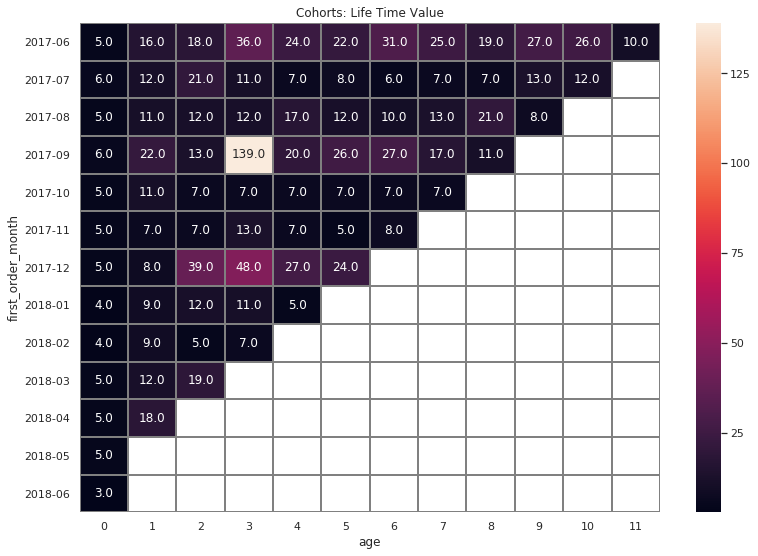

In [55]:
# let's plot LTV heatmap
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Life Time Value')
sns.heatmap(
    ltv_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray'
).set_yticklabels(ltv_pivot.index.strftime('%Y-%m'))
plt.show()

While checking average life time value for our users based on their first order and every month following their first order, we found that the most profitable was Sep'17 cohort that brought on its 4th term on average value equels to '139'; next one also on the 4th term was the Dec'17 cohort with '48' as an average life time value. In average 1st cohort brought '259' during its 12 terms. It is still less than Sep'17 cohort with average life time value of '281'.

In [56]:
#let's find how much buying users bring per month
cohorts = orders[['revenue','visits_month']].groupby(['visits_month']).sum().reset_index()

In [57]:
#let's find number of buying users 
cohorts_size = orders_stat.groupby('visits_month_x').agg({'uid': 'nunique'}).reset_index()


In [58]:
cohorts_size.columns = ['order_month', 'n_buyers']
cohorts.columns = ['order_month', 'revenues']

In [59]:
#let's find LTV 

report = pd.merge(cohorts_size, cohorts, on='order_month')

report['ltv'] = report['revenues'] / report['n_buyers']

result = report.pivot_table(
    index='order_month',  
    values='ltv', 
    aggfunc='mean').round(2).reset_index()

result.fillna('')

,order_month,ltv
0,1,6.01
1,2,7.23
2,3,8.41
3,4,7.55
4,5,7.05
5,6,5.01
6,7,7.00
7,8,6.78
8,9,7.70
9,10,6.86


In [60]:
#report
report.sort_values('ltv', ascending=[False]).tail(3)

,order_month,n_buyers,revenues,ltv
7,8,1291,8758.78,6.784493
0,1,3232,19417.13,6.007775
5,6,1909,9560.91,5.008334


In [61]:
report.sort_values('ltv', ascending=[False]).head(3)

,order_month,n_buyers,revenues,ltv
11,12,4167,36388.60,8.732565
2,3,3429,28834.59,8.409038
8,9,2384,18345.51,7.695264


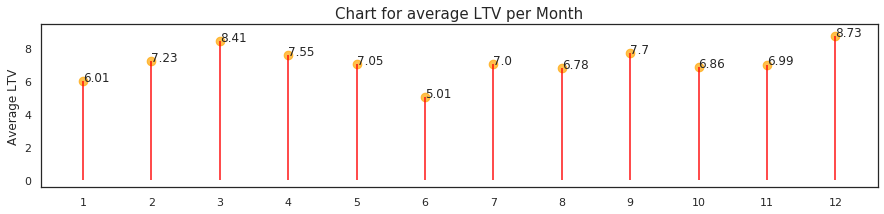

In [62]:
# let's plot chart for LTV per month 

fig,ax=plt.subplots(figsize=(15,3))
ax.vlines(x=report.order_month, ymin=0, ymax=report.ltv, color='red', alpha=0.7,linewidth=2)
ax.set_title('Chart for average LTV per Month', fontdict={'size':15})
ax.set_ylabel('Average LTV')
ax.set_xticks(report.order_month)
ax.scatter(x=report.order_month, y=report.ltv, s=75, color='orange', alpha=0.7)
for row in report.itertuples():
    ax.text(row.order_month, row.ltv, s=round(row.ltv, 2))

The max average LTV was brought on December'17 (8.7), March'18 (8.4) and September'17 (7.7) and min average LTV was in June'17 (5), January'18 (6), August'17 (6.7). 

### Part 3: Marketing
    * 		How much money was spent? Overall/per source/over time
    * 		How much did customer acquisition from each of the sources cost?
    * 		How worthwhile where the investments? (ROI)

#### 3.1. How much money was spent: Overall/per source/over time

In [63]:
print('Overall was spent:', int(costs.costs.sum()))

Overall was spent: 327877


In [64]:
costs['order_month'] = costs['dt'].dt.month


In [65]:
monthly_costs = costs.groupby('order_month').sum().reset_index().sort_values(by='costs', ascending=False)
monthly_costs[['order_month','costs']].head()

,order_month,costs
11,12,38217
10,11,37808
9,10,36213
0,1,33407
1,2,32626


In [66]:
monthly_costs.costs.sum()

327877

In [67]:
costs.costs.sum()

327877

In [68]:
monthly_costs = costs.groupby(['order_month','source_id']).sum().reset_index()
monthly_costs.head()

,order_month,source_id,costs
0,1,1,2169
1,1,2,4142
2,1,3,14791
3,1,4,5818
4,1,5,5356


In [69]:
source_id_overall = costs.groupby('source_id').sum().reset_index()
source_id_overall = source_id_overall[['source_id','costs']]
source_id_overall.sort_values(by='costs', ascending = False)

,source_id,costs
2,3,141144
3,4,60900
4,5,51565
1,2,42626
0,1,20660
6,10,5645
5,9,5337


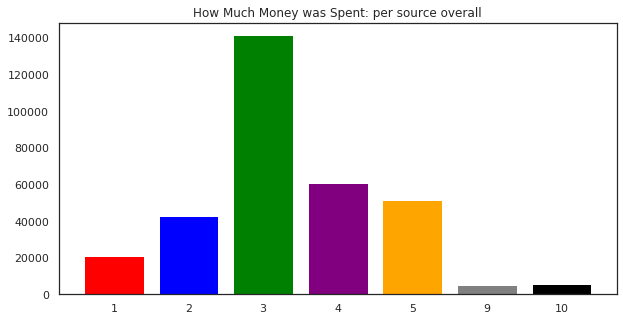

In [70]:
plt.figure(figsize=(10,5))
plt.title('How Much Money was Spent: per source overall')
y_pos = np.arange(len(source_id_overall.costs))
plt.bar(y_pos, source_id_overall.costs, color=['red', 'blue', 'green', 'purple', 'orange', 'grey', 'black'])
plt.xticks(y_pos, source_id_overall.source_id)
plt.show()



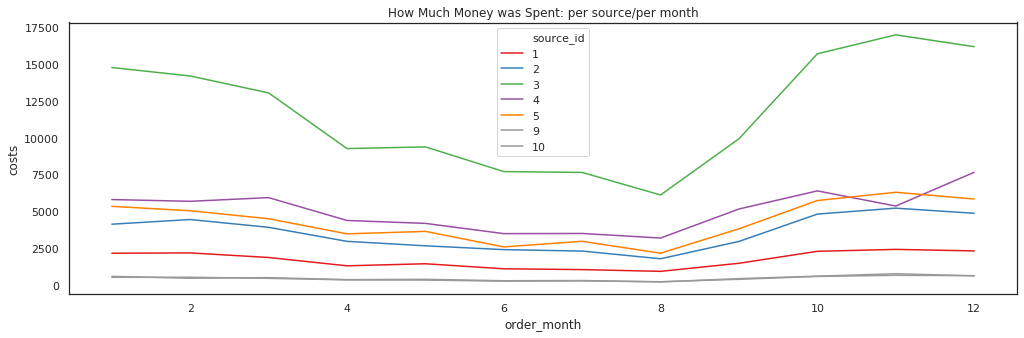

In [71]:
plt.figure(figsize=(17,5))
plt.title('How Much Money was Spent: per source/per month')
sns.set_style("whitegrid")
sns.lineplot(data=monthly_costs, x="order_month",y="costs", legend="full", hue="source_id", palette="Set1")
plt.show()

In [72]:
monthly_costs.sort_values(by='costs', ascending = False).head(3)

,order_month,source_id,costs
72,11,3,17010
79,12,3,16206
65,10,3,15723


We can see that the highest costs are coming from the source_id 3: Nov'17 - 17 010; Dec'17 - 16 206; Oct'17 - 15 723.

Overall top 3 costs source are as follows:	3 - 141144; 4 -	60900; 5 - 51565.
Overall was spent: 327877. 
Top 3 months by money spent by user (regardless the source): Dec'17 - 38217; Nov'17 - 37808; Oct'17 - 36213.

In [73]:
report

,order_month,n_buyers,revenues,ltv
0,1,3232,19417.13,6.007775
1,2,3535,25560.54,7.230704
2,3,3429,28834.59,8.409038
3,4,2233,16858.06,7.549512
4,5,2941,20735.98,7.050656
5,6,1909,9560.91,5.008334
6,7,1791,12539.47,7.001379
7,8,1291,8758.78,6.784493
8,9,2384,18345.51,7.695264
9,10,4082,27987.70,6.856369


#### 3.2. How much did customer acquisition from each of the month cost (CAC)

In [74]:
#Let's see how much did customer acquisition from each of the month cost (CAC)
costs_mnth = costs[['costs','order_month']]
costs_mnth = costs_mnth.groupby('order_month').sum().reset_index()
#costs_mnth.costs.sum()
report_ = pd.merge(report, costs_mnth,  on='order_month')
report_['cac'] = report_['costs'] / report_['n_buyers']

In [75]:
report_

,order_month,n_buyers,revenues,ltv,costs,cac
0,1,3232,19417.13,6.007775,33407,10.336324
1,2,3535,25560.54,7.230704,32626,9.229420
2,3,3429,28834.59,8.409038,30312,8.839895
3,4,2233,16858.06,7.549512,22189,9.936856
4,5,2941,20735.98,7.050656,22118,7.520571
5,6,1909,9560.91,5.008334,17916,9.385018
6,7,1791,12539.47,7.001379,18129,10.122278
7,8,1291,8758.78,6.784493,14684,11.374129
8,9,2384,18345.51,7.695264,24258,10.175336
9,10,4082,27987.70,6.856369,36213,8.871387


In [76]:
output_cac_mnth = report_.pivot_table(
    index='order_month',  
    values='cac', 
    aggfunc='mean').reset_index()
output_cac_mnth

,order_month,cac
0,1,10.336324
1,2,9.229420
2,3,8.839895
3,4,9.936856
4,5,7.520571
5,6,9.385018
6,7,10.122278
7,8,11.374129
8,9,10.175336
9,10,8.871387


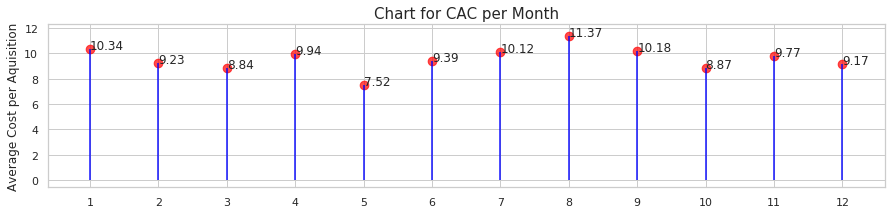

In [77]:
# let's plot chart for average CAC per month 

fig,ax=plt.subplots(figsize=(15,3))
ax.vlines(x=output_cac_mnth.order_month, ymin=0, ymax=output_cac_mnth.cac, color='blue', alpha=0.7,linewidth=2)
ax.set_title('Chart for CAC per Month', fontdict={'size':15})
ax.set_ylabel('Average Cost per Aquisition')
ax.set_xticks(output_cac_mnth.order_month)
ax.scatter(x=output_cac_mnth.order_month, y=output_cac_mnth.cac, s=75, color='red', alpha=0.7)
for row in output_cac_mnth.itertuples():
    ax.text(row.order_month, row.cac, s=round(row.cac, 2))

We can see that the lowest CAC was in May'18 - 7.52 (probably as it was the beginning of the analysis), the next lowest CAC was in Mar'18 - 8.84; the highest CAC was in Aug'17 - 11.37.

#### 3.3. How worthwhile were the investments (ROMI)


In [78]:
#Let's check now how worthwhile were the investments (ROI)
report_['romi'] = report_['ltv'] / report_['cac']
report_

,order_month,n_buyers,revenues,ltv,costs,cac,romi
0,1,3232,19417.13,6.007775,33407,10.336324,0.581229
1,2,3535,25560.54,7.230704,32626,9.229420,0.783441
2,3,3429,28834.59,8.409038,30312,8.839895,0.951260
3,4,2233,16858.06,7.549512,22189,9.936856,0.759749
4,5,2941,20735.98,7.050656,22118,7.520571,0.937516
5,6,1909,9560.91,5.008334,17916,9.385018,0.533652
6,7,1791,12539.47,7.001379,18129,10.122278,0.691680
7,8,1291,8758.78,6.784493,14684,11.374129,0.596485
8,9,2384,18345.51,7.695264,24258,10.175336,0.756266
9,10,4082,27987.70,6.856369,36213,8.871387,0.772863


In [79]:
output_romi_source = report_.pivot_table(
    index='order_month', 
    values='romi', 
    aggfunc='mean').reset_index()
output_romi_source

,order_month,romi
0,1,0.581229
1,2,0.783441
2,3,0.951260
3,4,0.759749
4,5,0.937516
5,6,0.533652
6,7,0.691680
7,8,0.596485
8,9,0.756266
9,10,0.772863


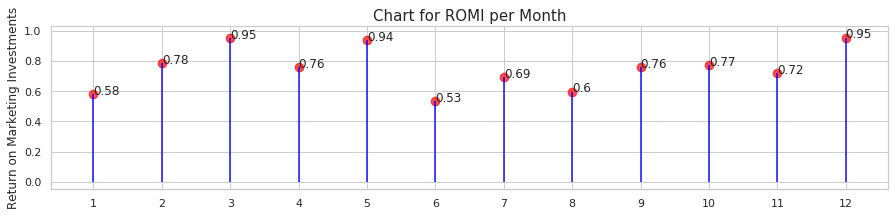

In [80]:
# let's plot chart for average ROMI per month 

fig,ax=plt.subplots(figsize=(15,3))
ax.vlines(x=output_romi_source.order_month, ymin=0, ymax=output_romi_source.romi, color='blue', alpha=0.7,linewidth=2)
ax.set_title('Chart for ROMI per Month', fontdict={'size':15})
ax.set_ylabel('Return on Marketing Investments')
ax.set_xticks(output_romi_source.order_month)
ax.scatter(x=output_romi_source.order_month, y=output_romi_source.romi, s=75, color='red', alpha=0.7)
for row in output_romi_source.itertuples():
    ax.text(row.order_month, row.romi, s=round(row.romi, 2))

We can see that the lowest ROMI was in Jun'17 - 0.53; the highest ROMI was in Dec'17 and Mar'18 - 0.95.

## Step 3: Conclusion

In the present reserach we studhied **Yandex.Afisha** data, helping to optimize marketing expenses. We learnt how people use the product; when they start to buy; how much money each customer brings; when they pay off.

We had 3 data sets:
* Server logs with data on Yandex.Afisha visits from June 2017 through May 2018 - **visits** table
    * Its total length is 359400 rows, every row represents one server log with data on website visits and its characteristics in columns: Uid — user's unique identifier; Device — user's device; Start Ts — session start date and time; End Ts — session end date and time; Source Id — identifier of the ad source the user came from.

* Dump file with all orders for the period - **orders** table
    * Its total length is 50415 rows, every row represents one order and its characteristics in columns: Uid — unique identifier of the user making an order; Buy Ts — order date and time; Revenue — Yandex.Afisha's revenue from the order.

* Marketing expenses statistics - **costs** table
    * Its total length is 2542 rows, every row represents one marketing expense and its characteristics in columns: source_id — ad source identifier; dt — date; costs — expenses on this ad source on this day.

In the first part of our analysis we checked the **Product**.
So, how many people use it every day, week, and month:
- the number of daily active (unique) users: 907
- the number of weekly active users: 5716
- the number of monthly active users: 23228

We found that 3% if unique users return to the app on the weekly (sticky WAU) basis and 15 % on the monthly basis (sticky MAU). 
In addition, we saw on our graph that the minimum number of users was in the week 22 in 2017 (beginning of our data set) while the spike of the daily and monthly active users was in Nov'17 (that is around week 46-47).
*Note: our data contains visits from June 2017 through May 2018, thus in 2017 week 22 was in June, while in 2018 it was in May, that's why we saw week 22 twice on our WAU graph.

Regarding the number of sessions we found that in average there were around 1000-1500 sessions a day from Sep’17 through Mar’18. In the same time there were couple of spikes on the 24-25 of Nov’17 with more than 4000 sessions and on the 31 of May’18 - 2300 sessions; a drop to 0 was on the 30-31 of Mar’18.

While checking the session duration we saw that the average session lasts 643 seconds, maximum length was 84480 sec (almost 24h) and the median was 300 seconds while the standard deviation was 1016 seconds.

When answering the question how often do users come back we found that the best result was for users from Sep'17 cohort (starting their activity in Sep’17), 10% of them kept coming back the two month (Nov’17); also 9% of Jan'18 cohort came back in the next period (Feb’18).

In the second part of our analysis we checked the **Sales**.

In our stat we saw that from 2281 69 users who visited the service, 36 523 unique users made an order and became customers (was “converted”) that is 16% from total. Thus, 11% of users made an order at their first day, 12 % of users became customers within 7 days from the first visit, 13% - within 14 days and 13% within 30 days. In average, it took about 17 days from the first visit for the customer to make an order. 

While checking convrsion by monthly cohorts - from first session, we can see that the best result was in Oct'17 cohort with 3302 d0 conversions, then was Dec'17 cohort with 2992 d0 conversions. The best within first 7 days was Nov'17 cohort with 415 conversions. The best within first 14 days was Nov'17 cohort with 163 conversions. The best within first 30 days was Nov'17 cohort with 190 conversions. The best within more than 30 days was Jun'17 cohort with 794 conversions. 

We can see that maximum amount of orders per day was done on the 24 of Nov’17  with more than 1200 orders; then on 31 of May’18 - 721 orders on 10 of Jun’17 - 428 (the very beginning of our data set statistics). We saw on our graph that from Sep’17 to Apr’18  there were stable fluctuations mainly between 200 and 400 daily orders except the spike mentioned earlier for Nov’17.

Regarding average purchase size per day, 3 days with the max average was on the 10 of Dec’17 - 29, then on the 14 of Jun’17 - 28,  and on the 21 of Sep’17 - 27. 

**While checking average life time value (LTV) for our users based on their first order and every month following their first order (max 12 terms for the 1sr cohort), we found that the most profitable was Sep'17 cohort that brought on its 4th term an average value equels to '139'; next one also on the 4th term was the Dec'17 cohort with '48' as an average life time value. In average, 1st cohort brought '259' during its 12 terms. It is still less than Sep'17 cohort with average life time value of '281'.**

In the second part of our analysis we checked the **Marketing**.

As per our data, overall was spent: 327 877. We can see that the highest costs were coming from the source_id 3: Nov'17 - 17 010; Dec'17 - 16 206; Oct'17 - 15 723.
Overall top 3 revenues sources were as follows: 3 - 141 144; 4 - 60 900; 5 - 51 565. Top 3 months by money spent by user (regardless the source): Dec'17 - 38 217; Nov'17 - 37 808; Oct'17 - 36 213.
While checking Customer Acquisition Cost (CAC) we saw that the lowest CAC was in May'18 - 7.52, the next lowest CAC was in Mar'18 - 8.84; the highest CAC was in Aug'17 - 11.37.
What about worthwhile were the investments we saw that the lowest ROMI was in Jun'17 - 0.53; the highest ROMI was in Dec'17 and Mar'18 - 0.95.

In general, as we were checking Yandex.Afisha service that offers tickets to the various events, theatres, shows etc, we could find some impact of seasonality with summer break in the events and new year celebrations.